In [1]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr#;xr.set_options(display_style='text') 
import datetime


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

import cartopy.crs as ccrs
import cartopy

import sys
p = '/global/homes/q/qnicolas'
if p not in sys.path:
    sys.path.append(p)

from tools.wrfHrTools import *
from tools.generalTools import qsat,compute_N
from orographicConvectionTheory.orographicConvectionTheory import topographic_profile,k_vector


SCRATCH='/global/cscratch1/sd/qnicolas/'

import scipy.linalg as spl
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d

%load_ext autoreload
%autoreload 2

In [2]:
DZ = 100.
zz_full = np.arange(0.,20e3,DZ)
N0=0.01;U0=10;k0=2*np.pi/100e3;hhat0=1.
q0 = 0.02*np.exp(-zz_full/2e3)
dq0dz = np.gradient(q0,zz_full)

# Functions

In [3]:
kuangdata = loadmat("/global/u2/q/qnicolas/orographicPrecipitation/steadyLRF.mat")

Mkuang=kuangdata['M']
pres=kuangdata['pres'][:,0]
tmean=kuangdata['tmean'][:,0]
qmean=kuangdata['qmean'][:,0]
zrce = kuangdata['z'][:,0]
zT = zrce[:-2]
zQ = zrce[:14]

#Reverse positive eigenvalue
lambdas,P = spl.eig(Mkuang)
lambdas[5]*=-1
Pm1 = spl.inv(P)
Mkuang2 = np.real(np.dot(np.dot(P,np.diag(lambdas)),Pm1))

In [4]:
from calc_GW_LRF import *

In [5]:
g = 9.81
Lv = 2.5e6
cp=1004.
Rd = 287.
T0=300.

In [6]:
MT = make_interp_matrix(zz_full,zrce[:26])
Mq = make_interp_matrix(zz_full,zrce[:14])
MTm1 = make_interp_matrix(zrce[:26],zz_full)
Mqm1 = make_interp_matrix(zrce[:14],zz_full)

# Coupling function

In [8]:
def coupled_gw_mode_2(z,zrce,ds0dz,dq0dz,k,hhatk,U0,MM,itp_matrices=None,mode='iterative',niter=10):
    """Computes one wave mode by solving the linear wave equation:
    d2/dz2(w_hat) + (l(z)^2-k^2)w_hat = q_hat, subject to BCs
    w_hat(k,z=0) = ikU(z=0)h_hat(k) 
    & d w_hat(k,ztop) = i m(ztop) w_hat(k,ztop), where m(ztop) is defined to satisfy a radiation BC or an evanescent BC at the top
    """
    n = len(z)
    dz = z[1]-z[0]
    
    A = make_A(z,ds0dz*g/T0/U0**2,k)
    
    if itp_matrices is None:
        itp1_matrix = np.block([[make_interp_matrix(z,zrce[:26]),np.zeros((26,len(z)))],[np.zeros((14,len(z))),make_interp_matrix(z,zrce[:14])]])
        itp2_matrix = make_interp_matrix(zrce[:26],z)
        itp3_matrix = np.block([[itp2_matrix,np.zeros((len(z),14))],[np.zeros((len(z),26)),make_interp_matrix(zrce[:14],z)]])
    else: 
        itp1_matrix,itp2_matrix,itp3_matrix = itp_matrices
        
    MM = MM/86400
    MM[:,26:]*=1000
    MM[26:]/=1000
    MMitp = np.linalg.multi_dot((itp3_matrix,MM,itp1_matrix))
    
    eye_ = np.eye(n)
    eye_[0] = 0.
    eye_[-1] = 0.
    lhs_matrix = np.block([[ A              , np.zeros((n,n))   , np.zeros((n,n))   , -eye_*g/T0/U0**2     , np.zeros((n,n))],
                           [ np.diag(ds0dz) , 1j*k*U0*np.eye(n) , np.zeros((n,n))   , - np.eye(n)          , np.zeros((n,n))],
                           [ np.diag(dq0dz) , np.zeros((n,n))   , 1j*k*U0*np.eye(n) , np.zeros((n,n))      , - np.eye(n)    ],
                           [                  np.zeros((2*n,3*n))                   ,                np.eye(2*n)            ]
                          ])
    
    rhs_matrix = np.block([[               np.zeros((3*n,5*n))               ],
                           [ np.zeros((2*n,n)) , MMitp , np.zeros((2*n,2*n)) ]
                          ])
    rhs_vec = np.zeros(5*n)*1j
    rhs_vec[0] = 1j*k*U0*hhatk
    
    if mode=='matrices':
        return lhs_matrix,rhs_matrix
    
    if mode == 'iterative':
        all_ = np.linalg.solve(lhs_matrix,rhs_vec)
        for _ in range(niter):
            all_ = np.linalg.solve(lhs_matrix,np.dot(rhs_matrix,all_)+rhs_vec)
    else:
        all_ = np.linalg.solve(lhs_matrix-rhs_matrix,rhs_vec)
    ww = all_[:n]
    Tprime = all_[n:2*n]
    qprime = all_[2*n:3*n]
    Qc = all_[3*n:4*n]
    Qq = all_[4*n:]
    return ww,Tprime,qprime,Qc,Qq


# With uniform stratification & exponential q0(z)

Text(0.5, 1.0, 'Qc (K/day)')

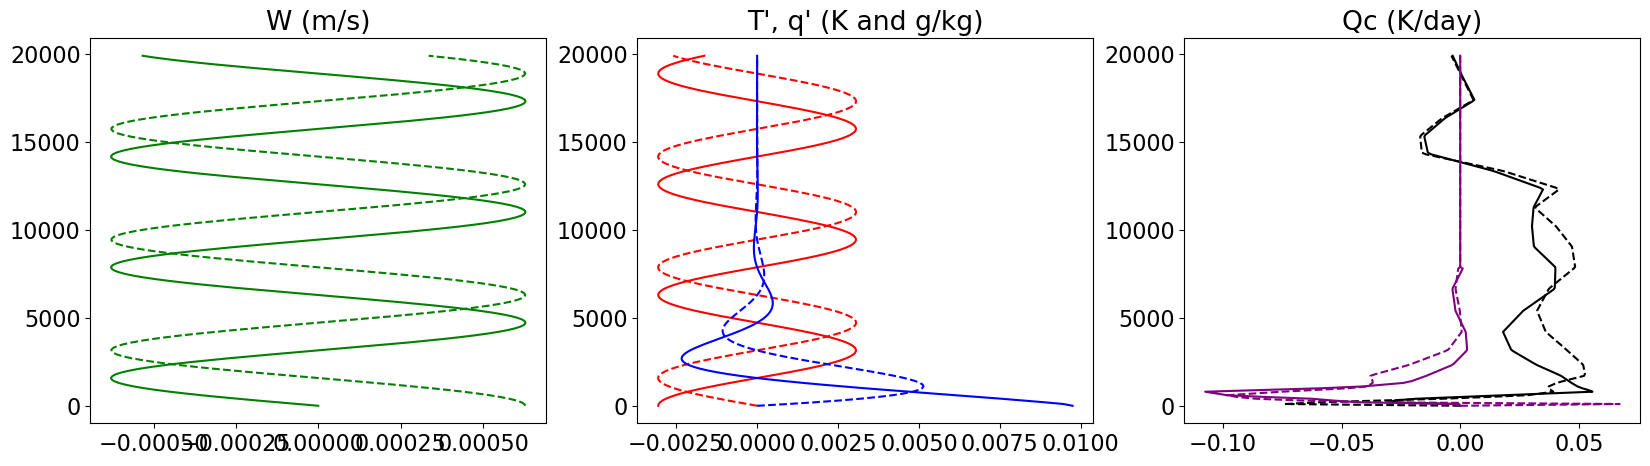

In [45]:
ww = gw_mode_forced(zz_full,0*zz_full+N0**2/U0**2,k0,hhat0,U0,0*zz_full)

bprime = -ww*N0**2/(1j*k0*U0)
Tprime = bprime/g*300.
qprime = -ww*dq0dz/(1j*k0*U0)*1e3

QcQq_rcegrid = np.dot(Mkuang2,np.concatenate((np.dot(MT,Tprime),np.dot(Mq,qprime))))
Qc = np.dot(MTm1,QcQq_rcegrid[:26])
Qq = np.dot(Mqm1,QcQq_rcegrid[26:])

_,axs = plt.subplots(1,3,figsize=(20,5))
axs[0].plot(np.real(ww),zz_full,color='g')
axs[0].plot(np.imag(ww),zz_full,color='g',linestyle='--')
axs[1].plot(np.real(Tprime),zz_full,color='r')
axs[1].plot(np.imag(Tprime),zz_full,color='r',linestyle='--')
axs[1].plot(np.real(qprime),zz_full,color='b')
axs[1].plot(np.imag(qprime),zz_full,color='b',linestyle='--')

axs[2].plot(np.real(Qc),zz_full,color='k',linestyle='-')
axs[2].plot(np.imag(Qc),zz_full,color='k',linestyle='--')
axs[2].plot(np.real(Qq),zz_full,color='purple',linestyle='-')
axs[2].plot(np.imag(Qq),zz_full,color='purple',linestyle='--')
axs[0].set_title('W (m/s)')
axs[1].set_title("T', q' (K and g/kg)")
axs[2].set_title('Qc (K/day)')

Text(0.5, 1.0, 'Qc (K/day)')

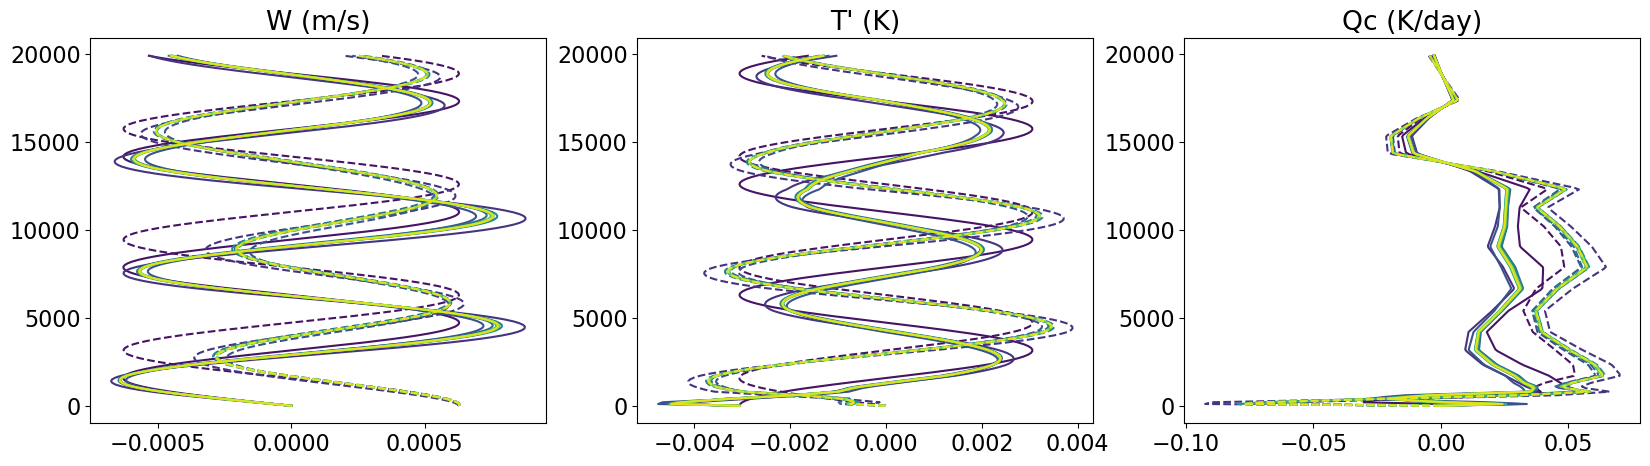

In [19]:
def iterate(niter):
    ww = gw_mode_forced(zz_full,0*zz_full+N0**2/U0**2,k0,hhat0,U0,0*zz_full)
    Qc = 0.;Qq=0.
    ws=[];Ts=[];qs=[];Qcs=[];Qqs=[]
    for _ in range(niter):
        Tprime = (-ww*N0**2/g*300. + Qc/86400)/(1j*k0*U0)
        qprime = (-ww*dq0dz*1000 + Qq/(86400))/(1j*k0*U0)
        
        QcQq_rcegrid = np.dot(Mkuang2,np.concatenate((np.dot(MT,Tprime),np.dot(Mq,qprime))))
        Qc = np.dot(MTm1,QcQq_rcegrid[:26])
        Qq = np.dot(Mqm1,QcQq_rcegrid[26:])
        
        ws.append(ww);Ts.append(Tprime);qs.append(qprime);Qcs.append(Qc);Qqs.append(Qq)
        ww = gw_mode_forced(zz_full,0*zz_full+N0**2/U0**2,k0,hhat0,U0,Qc*g/300./86400/U0**2)
    return ws,Ts,qs,Qcs,Qqs

N=10
ws,Ts,qs,Qcs,Qqs = iterate(N)
_,axs = plt.subplots(1,3,figsize=(20,5))
colors = plt.cm.viridis(np.linspace(0.05,0.95,N))
for i in range(N):
    axs[0].plot(np.real(ws[i]),zz_full,color=colors[i])
    axs[0].plot(np.imag(ws[i]),zz_full,color=colors[i],linestyle='--')
    axs[1].plot(np.real(Ts[i]),zz_full,color=colors[i])
    axs[1].plot(np.imag(Ts[i]),zz_full,color=colors[i],linestyle='--')
    axs[2].plot(np.real(Qcs[i]),zz_full,color=colors[i])
    axs[2].plot(np.imag(Qcs[i]),zz_full,color=colors[i],linestyle='--')
axs[0].set_title('W (m/s)')
axs[1].set_title("T' (K)")
axs[2].set_title('Qc (K/day)')

In [22]:
wCOUPLED,TCOUPLED,qCOUPLED,QcCOUPLED,QqCOUPLED = coupled_gw_mode_2(zz_full,zrce,0*zz_full+N0**2*T0/g,dq0dz,k0,hhat0,U0,Mkuang2,mode='iterative',niter=40)
wADIAB = gw_mode_forced(zz_full,0*zz_full+N0**2/U0**2,k0,hhat0,U0,0*zz_full)

TADIAB = -wADIAB*N0**2/g*300./(1j*k0*U0)
qADIAB = -wADIAB*dq0dz/(1j*k0*U0)
QcQq_rcegrid = np.dot(Mkuang2,np.concatenate((np.dot(MT,TADIAB),np.dot(Mq,qADIAB*1e3))))
QcADIAB = np.dot(MTm1,QcQq_rcegrid[:26])/86400
QqADIAB = np.dot(Mqm1,QcQq_rcegrid[26:])/86400/1e3


(-0.18, 0.18)

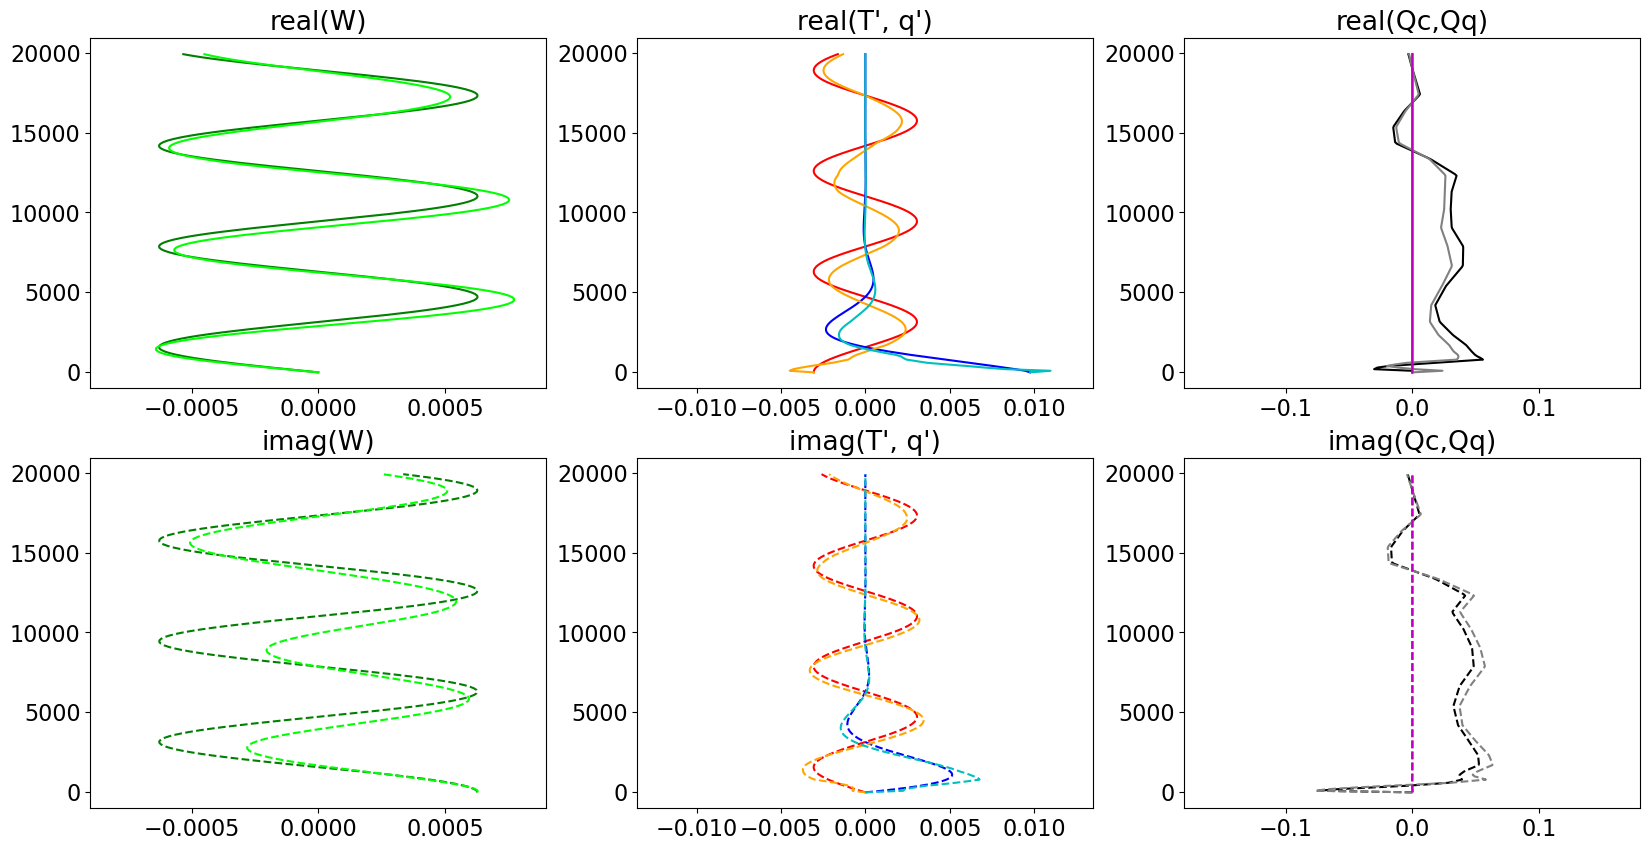

In [23]:
_,axs = plt.subplots(2,3,figsize=(20,10))
colorsw = ['g','lime']
colorsT = ['r','orange']
colorsq = ['b','c']
colorsQc = ['k','gray']
colorsQq = ['purple','m']

i=0
axs[0,0].plot(np.real(wADIAB),zz_full,color=colorsw[i])
axs[0,1].plot(np.real(TADIAB),zz_full,color=colorsT[i])
axs[0,1].plot(np.real(1000*qADIAB),zz_full,color=colorsq[i])
axs[0,2].plot(np.real(86400*QcADIAB),zz_full,color=colorsQc[i])
axs[0,2].plot(np.real(86400*QqADIAB),zz_full,color=colorsQq[i])
axs[1,0].plot(np.imag(wADIAB),zz_full,color=colorsw[i],linestyle='--')
axs[1,1].plot(np.imag(TADIAB),zz_full,color=colorsT[i],linestyle='--')
axs[1,1].plot(np.imag(1000*qADIAB),zz_full,color=colorsq[i],linestyle='--')
axs[1,2].plot(np.imag(86400*QcADIAB),zz_full,color=colorsQc[i],linestyle='--')
axs[1,2].plot(np.imag(86400*QqADIAB),zz_full,color=colorsQq[i],linestyle='--')


i=1
axs[0,0].plot(np.real(wCOUPLED),zz_full,color=colorsw[i])
axs[0,1].plot(np.real(TCOUPLED),zz_full,color=colorsT[i])
axs[0,1].plot(np.real(1000*qCOUPLED),zz_full,color=colorsq[i])
axs[0,2].plot(np.real(86400*QcCOUPLED),zz_full,color=colorsQc[i])
axs[0,2].plot(np.real(86400*QqCOUPLED),zz_full,color=colorsQq[i])
axs[1,0].plot(np.imag(wCOUPLED),zz_full,color=colorsw[i],linestyle='--')
axs[1,1].plot(np.imag(TCOUPLED),zz_full,color=colorsT[i],linestyle='--')
axs[1,1].plot(np.imag(1000*qCOUPLED),zz_full,color=colorsq[i],linestyle='--')
axs[1,2].plot(np.imag(86400*QcCOUPLED),zz_full,color=colorsQc[i],linestyle='--')
axs[1,2].plot(np.imag(86400*QqCOUPLED),zz_full,color=colorsQq[i],linestyle='--')

    
axs[0,0].set_title('real(W)')
axs[0,1].set_title("real(T', q')")
axs[0,2].set_title('real(Qc,Qq)')
axs[1,0].set_title('imag(W)')
axs[1,1].set_title("imag(T', q')")
axs[1,2].set_title('imag(Qc,Qq)')
xlim =9e-4 ;axs[0,0].set_xlim(-xlim,xlim)  ;axs[1,0].set_xlim(-xlim,xlim)
xlim2=15*xlim ;axs[0,1].set_xlim(-xlim2,xlim2);axs[1,1].set_xlim(-xlim2,xlim2)
xlim3=200*xlim;axs[0,2].set_xlim(-xlim3,xlim3);axs[1,2].set_xlim(-xlim3,xlim3)

In [10]:
k1 = 4e-5
hhat1 = hhat0

wCOUPLED,TCOUPLED,qCOUPLED,QcCOUPLED,QqCOUPLED = coupled_gw_mode_2(zz_full,zrce,0*zz_full+N0**2*T0/g,dq0dz,k1,hhat0,U0,Mkuang2,mode='iterative',niter=40)
wADIAB = gw_mode_forced(zz_full,0*zz_full+N0**2/U0**2,k1,hhat1,U0,0*zz_full)

TADIAB = -wADIAB*N0**2/g*300./(1j*k1*U0)
qADIAB = -wADIAB*dq0dz/(1j*k1*U0)
QcQq_rcegrid = np.dot(Mkuang2,np.concatenate((np.dot(MT,TADIAB),np.dot(Mq,qADIAB*1e3))))
QcADIAB = np.dot(MTm1,QcQq_rcegrid[:26])/86400
QqADIAB = np.dot(Mqm1,QcQq_rcegrid[26:])/86400/1e3


(-0.18, 0.18)

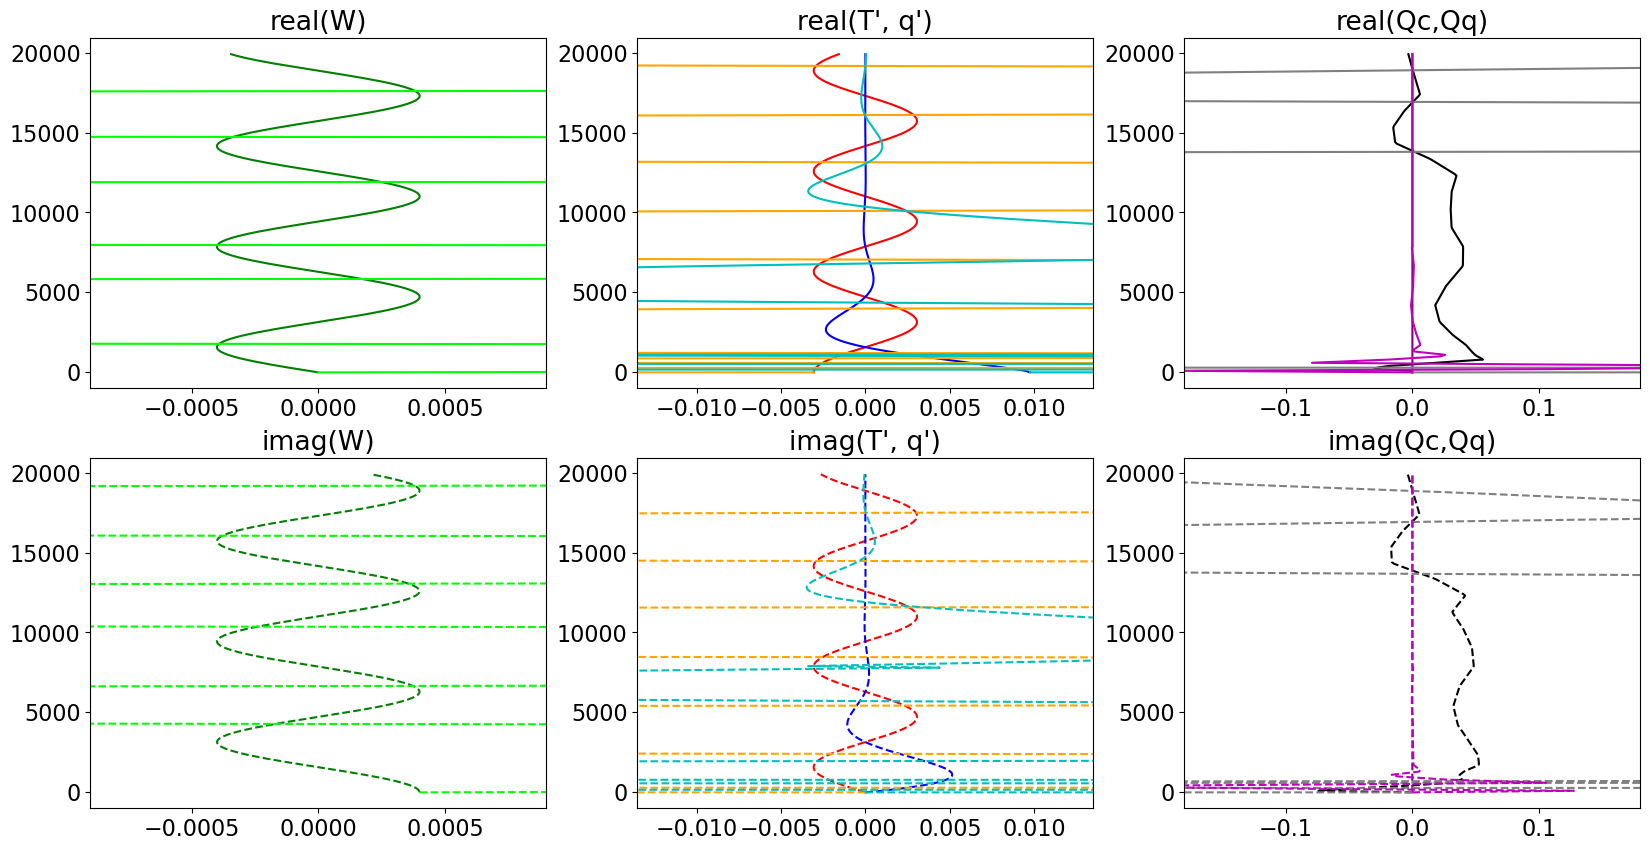

In [11]:
_,axs = plt.subplots(2,3,figsize=(20,10))
colorsw = ['g','lime']
colorsT = ['r','orange']
colorsq = ['b','c']
colorsQc = ['k','gray']
colorsQq = ['purple','m']

i=0
axs[0,0].plot(np.real(wADIAB),zz_full,color=colorsw[i])
axs[0,1].plot(np.real(TADIAB),zz_full,color=colorsT[i])
axs[0,1].plot(np.real(1000*qADIAB),zz_full,color=colorsq[i])
axs[0,2].plot(np.real(86400*QcADIAB),zz_full,color=colorsQc[i])
axs[0,2].plot(np.real(86400*QqADIAB),zz_full,color=colorsQq[i])
axs[1,0].plot(np.imag(wADIAB),zz_full,color=colorsw[i],linestyle='--')
axs[1,1].plot(np.imag(TADIAB),zz_full,color=colorsT[i],linestyle='--')
axs[1,1].plot(np.imag(1000*qADIAB),zz_full,color=colorsq[i],linestyle='--')
axs[1,2].plot(np.imag(86400*QcADIAB),zz_full,color=colorsQc[i],linestyle='--')
axs[1,2].plot(np.imag(86400*QqADIAB),zz_full,color=colorsQq[i],linestyle='--')


i=1
axs[0,0].plot(np.real(wCOUPLED),zz_full,color=colorsw[i])
axs[0,1].plot(np.real(TCOUPLED),zz_full,color=colorsT[i])
axs[0,1].plot(np.real(1000*qCOUPLED),zz_full,color=colorsq[i])
axs[0,2].plot(np.real(86400*QcCOUPLED),zz_full,color=colorsQc[i])
axs[0,2].plot(np.real(86400*QqCOUPLED),zz_full,color=colorsQq[i])
axs[1,0].plot(np.imag(wCOUPLED),zz_full,color=colorsw[i],linestyle='--')
axs[1,1].plot(np.imag(TCOUPLED),zz_full,color=colorsT[i],linestyle='--')
axs[1,1].plot(np.imag(1000*qCOUPLED),zz_full,color=colorsq[i],linestyle='--')
axs[1,2].plot(np.imag(86400*QcCOUPLED),zz_full,color=colorsQc[i],linestyle='--')
axs[1,2].plot(np.imag(86400*QqCOUPLED),zz_full,color=colorsQq[i],linestyle='--')

    
axs[0,0].set_title('real(W)')
axs[0,1].set_title("real(T', q')")
axs[0,2].set_title('real(Qc,Qq)')
axs[1,0].set_title('imag(W)')
axs[1,1].set_title("imag(T', q')")
axs[1,2].set_title('imag(Qc,Qq)')
xlim =9e-4 ;axs[0,0].set_xlim(-xlim,xlim)  ;axs[1,0].set_xlim(-xlim,xlim)
xlim2=15*xlim ;axs[0,1].set_xlim(-xlim2,xlim2);axs[1,1].set_xlim(-xlim2,xlim2)
xlim3=200*xlim;axs[0,2].set_xlim(-xlim3,xlim3);axs[1,2].set_xlim(-xlim3,xlim3)

In [41]:
k1 = 4e-6
hhat1 = hhat0

wCOUPLED,TCOUPLED,qCOUPLED,QcCOUPLED,QqCOUPLED = coupled_gw_mode_2(zz_full,zrce,0*zz_full+N0**2*T0/g,dq0dz,k1,hhat0,U0,Mkuang2,mode='coupled')
wADIAB = gw_mode_forced(zz_full,0*zz_full+N0**2/U0**2,k1,hhat0,U0,0*zz_full)

TADIAB = -wADIAB*N0**2/g*300./(1j*k0*U0)
qADIAB = -wADIAB*dq0dz/(1j*k0*U0)
QcQq_rcegrid = np.dot(Mkuang2,np.concatenate((np.dot(MT,TADIAB),np.dot(Mq,qADIAB*1e3))))
QcADIAB = np.dot(MTm1,QcQq_rcegrid[:26])/86400
QqADIAB = np.dot(Mqm1,QcQq_rcegrid[26:])/86400/1e3


Text(0.5, 1.0, 'imag(Qc,Qq)')

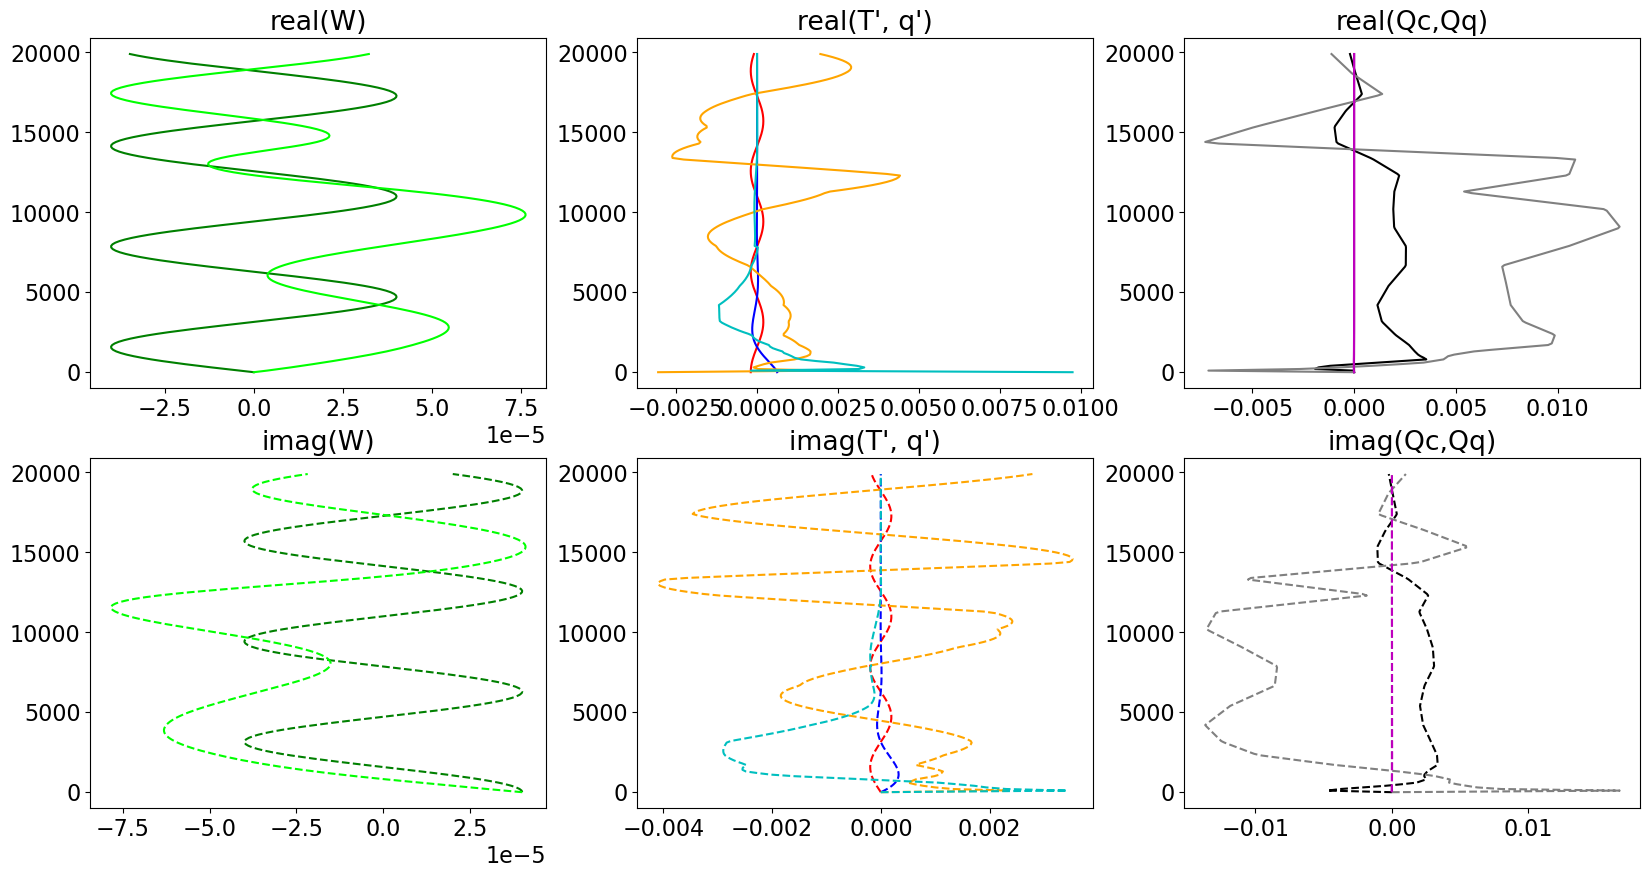

In [42]:
_,axs = plt.subplots(2,3,figsize=(20,10))
colorsw = ['g','lime']
colorsT = ['r','orange']
colorsq = ['b','c']
colorsQc = ['k','gray']
colorsQq = ['purple','m']

i=0
axs[0,0].plot(np.real(wADIAB),zz_full,color=colorsw[i])
axs[0,1].plot(np.real(TADIAB),zz_full,color=colorsT[i])
axs[0,1].plot(np.real(1000*qADIAB),zz_full,color=colorsq[i])
axs[0,2].plot(np.real(86400*QcADIAB),zz_full,color=colorsQc[i])
axs[0,2].plot(np.real(86400*QqADIAB),zz_full,color=colorsQq[i])
axs[1,0].plot(np.imag(wADIAB),zz_full,color=colorsw[i],linestyle='--')
axs[1,1].plot(np.imag(TADIAB),zz_full,color=colorsT[i],linestyle='--')
axs[1,1].plot(np.imag(1000*qADIAB),zz_full,color=colorsq[i],linestyle='--')
axs[1,2].plot(np.imag(86400*QcADIAB),zz_full,color=colorsQc[i],linestyle='--')
axs[1,2].plot(np.imag(86400*QqADIAB),zz_full,color=colorsQq[i],linestyle='--')


i=1
axs[0,0].plot(np.real(wCOUPLED),zz_full,color=colorsw[i])
axs[0,1].plot(np.real(TCOUPLED),zz_full,color=colorsT[i])
axs[0,1].plot(np.real(1000*qCOUPLED),zz_full,color=colorsq[i])
axs[0,2].plot(np.real(86400*QcCOUPLED),zz_full,color=colorsQc[i])
axs[0,2].plot(np.real(86400*QqCOUPLED),zz_full,color=colorsQq[i])
axs[1,0].plot(np.imag(wCOUPLED),zz_full,color=colorsw[i],linestyle='--')
axs[1,1].plot(np.imag(TCOUPLED),zz_full,color=colorsT[i],linestyle='--')
axs[1,1].plot(np.imag(1000*qCOUPLED),zz_full,color=colorsq[i],linestyle='--')
axs[1,2].plot(np.imag(86400*QcCOUPLED),zz_full,color=colorsQc[i],linestyle='--')
axs[1,2].plot(np.imag(86400*QqCOUPLED),zz_full,color=colorsQq[i],linestyle='--')

    
axs[0,0].set_title('real(W)')
axs[0,1].set_title("real(T', q')")
axs[0,2].set_title('real(Qc,Qq)')
axs[1,0].set_title('imag(W)')
axs[1,1].set_title("imag(T', q')")
axs[1,2].set_title('imag(Qc,Qq)')
#xlim =9e-4 ;axs[0,0].set_xlim(-xlim,xlim)  ;axs[1,0].set_xlim(-xlim,xlim)
#xlim2=15*xlim ;axs[0,1].set_xlim(-xlim2,xlim2);axs[1,1].set_xlim(-xlim2,xlim2)
#xlim3=200*xlim;axs[0,2].set_xlim(-xlim3,xlim3);axs[1,2].set_xlim(-xlim3,xlim3)

Conclusion: small k (below 4e-5 in this case) blows up

In [33]:
k1 = 4e-4
hhat1 = hhat0

wCOUPLED,TCOUPLED,qCOUPLED,QcCOUPLED,QqCOUPLED = coupled_gw_mode_2(zz_full,zrce,0*zz_full+N0**2*T0/g,dq0dz,k1,hhat0,U0,Mkuang2,mode='coupled',niter=40)
wADIAB = gw_mode_forced(zz_full,0*zz_full+N0**2/U0**2,k1,hhat1,U0,0*zz_full)

TADIAB = -wADIAB*N0**2/g*300./(1j*k1*U0)
qADIAB = -wADIAB*dq0dz/(1j*k1*U0)
QcQq_rcegrid = np.dot(Mkuang2,np.concatenate((np.dot(MT,TADIAB),np.dot(Mq,qADIAB*1e3))))
QcADIAB = np.dot(MTm1,QcQq_rcegrid[:26])/86400
QqADIAB = np.dot(Mqm1,QcQq_rcegrid[26:])/86400/1e3


(-0.18, 0.18)

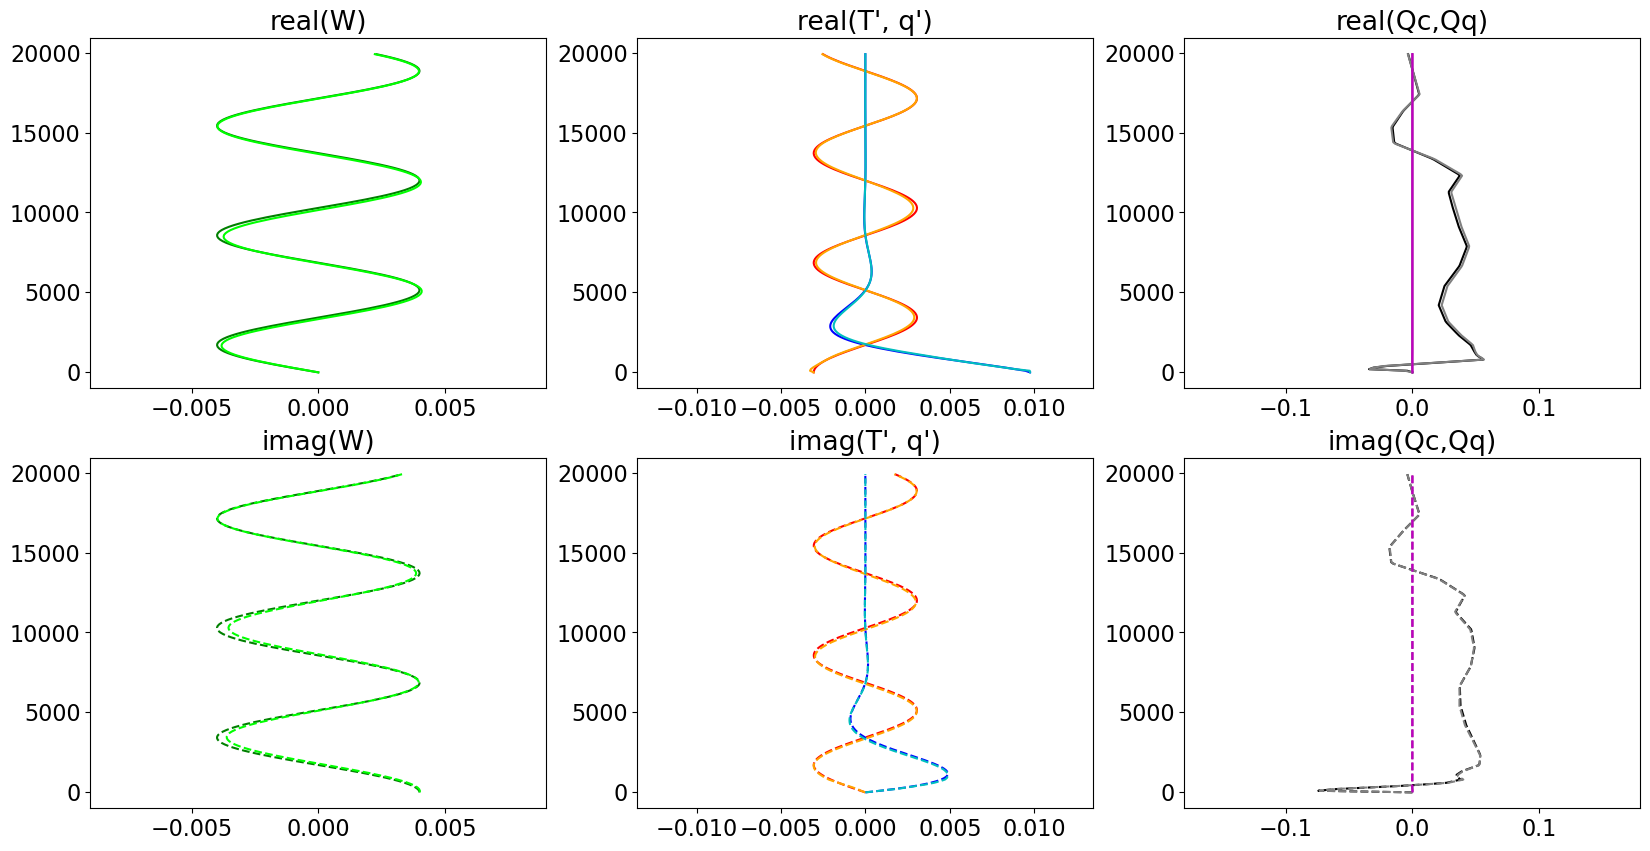

In [37]:
_,axs = plt.subplots(2,3,figsize=(20,10))
colorsw = ['g','lime']
colorsT = ['r','orange']
colorsq = ['b','c']
colorsQc = ['k','gray']
colorsQq = ['purple','m']

i=0
axs[0,0].plot(np.real(wADIAB),zz_full,color=colorsw[i])
axs[0,1].plot(np.real(TADIAB),zz_full,color=colorsT[i])
axs[0,1].plot(np.real(1000*qADIAB),zz_full,color=colorsq[i])
axs[0,2].plot(np.real(86400*QcADIAB),zz_full,color=colorsQc[i])
axs[0,2].plot(np.real(86400*QqADIAB),zz_full,color=colorsQq[i])
axs[1,0].plot(np.imag(wADIAB),zz_full,color=colorsw[i],linestyle='--')
axs[1,1].plot(np.imag(TADIAB),zz_full,color=colorsT[i],linestyle='--')
axs[1,1].plot(np.imag(1000*qADIAB),zz_full,color=colorsq[i],linestyle='--')
axs[1,2].plot(np.imag(86400*QcADIAB),zz_full,color=colorsQc[i],linestyle='--')
axs[1,2].plot(np.imag(86400*QqADIAB),zz_full,color=colorsQq[i],linestyle='--')


i=1
axs[0,0].plot(np.real(wCOUPLED),zz_full,color=colorsw[i])
axs[0,1].plot(np.real(TCOUPLED),zz_full,color=colorsT[i])
axs[0,1].plot(np.real(1000*qCOUPLED),zz_full,color=colorsq[i])
axs[0,2].plot(np.real(86400*QcCOUPLED),zz_full,color=colorsQc[i])
axs[0,2].plot(np.real(86400*QqCOUPLED),zz_full,color=colorsQq[i])
axs[1,0].plot(np.imag(wCOUPLED),zz_full,color=colorsw[i],linestyle='--')
axs[1,1].plot(np.imag(TCOUPLED),zz_full,color=colorsT[i],linestyle='--')
axs[1,1].plot(np.imag(1000*qCOUPLED),zz_full,color=colorsq[i],linestyle='--')
axs[1,2].plot(np.imag(86400*QcCOUPLED),zz_full,color=colorsQc[i],linestyle='--')
axs[1,2].plot(np.imag(86400*QqCOUPLED),zz_full,color=colorsQq[i],linestyle='--')

    
axs[0,0].set_title('real(W)')
axs[0,1].set_title("real(T', q')")
axs[0,2].set_title('real(Qc,Qq)')
axs[1,0].set_title('imag(W)')
axs[1,1].set_title("imag(T', q')")
axs[1,2].set_title('imag(Qc,Qq)')
xlim =9e-3 ;axs[0,0].set_xlim(-xlim,xlim)  ;axs[1,0].set_xlim(-xlim,xlim)
xlim2=1.5*xlim ;axs[0,1].set_xlim(-xlim2,xlim2);axs[1,1].set_xlim(-xlim2,xlim2)
xlim3=20*xlim;axs[0,2].set_xlim(-xlim3,xlim3);axs[1,2].set_xlim(-xlim3,xlim3)